## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Загружаем исходные данные

In [2]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [3]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [4]:
train_img.shape

(42000, 28, 28)

## Визуализируем исходные данные

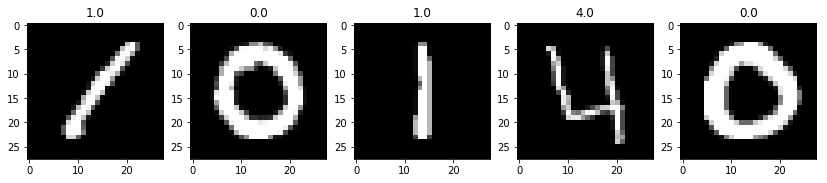

In [5]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

# Обработка изображений

Получаем границы изображения с помощью Лапласиана, также это позволит избавиться от учета толщины написания цифры.

In [6]:
train_lapl = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_lapl[i] = cv2.Laplacian(train_img[i], cv2.CV_64F, ksize=5)

In [7]:
test_lapl = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_lapl[i] = cv2.Laplacian(test_img[i], cv2.CV_64F, ksize =5)

In [8]:
train_lapl = train_lapl.clip(0) # уберем отр. значения

In [9]:
test_lapl = test_lapl.clip(0) # уберем отр. значения

Можно заметить, что сумма значений ярокости по строкам вдоль вертикальной оси в матрице пискелей возможно дает возможность отличить "верх/низ" рукописной цифры. Попробуем просуммировать все элементы матрицы в строке. Полученный вектор представим нормированной гистограммой.

In [10]:
train_ln = np.zeros((len(train_img), 28))
for i in range(len(train_img)):
    train_ln[i] = train_lapl[i].sum(axis = 1)/np.linalg.norm(train_lapl[i].sum(axis = 1))    

In [11]:
test_ln = np.zeros((len(test_img), 28))
for i in range(len(test_img)):
    test_ln[i] = test_lapl[i].sum(axis = 1)/np.linalg.norm(test_lapl[i].sum(axis = 1))    

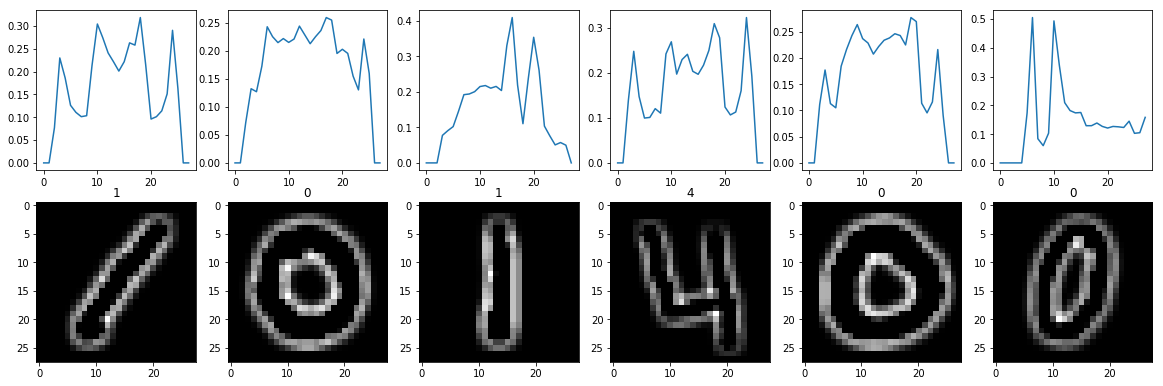

In [12]:
fig2 = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_lapl[: 6],1):    
    subplot2 = fig2.add_subplot(1,6,i)
    plt.imshow(img, cmap='gray')
    plt.title('%d' % train_label[i - 1])
    subplot = fig2.add_subplot(3,6, i)
    plt.plot(range(0,28),train_ln[i])

## Разбиваем выборку на обучение и валидацию

In [13]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_ln, test_size=0.2,
    random_state=42)

In [14]:
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.decomposition import pca

In [15]:
log_clf = LogisticRegression()
svm_clf = svm.SVC()

SVM

In [16]:
svm_param  = { 'C' : np.array(range(1,27,3))*0.1,
              'decision_function_shape' : ['ovo', 'ovr']    
}

In [17]:
grid = GridSearchCV(svm_clf, svm_param, scoring = 'accuracy', verbose = 5, n_jobs = -1)

In [18]:
%%time
grid.fit(x_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed: 33.1min finished


Wall time: 34min 5s


GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': array([0.1, 0.4, 0.7, 1. , 1.3, 1.6, 1.9, 2.2, 2.5]), 'decision_function_shape': ['ovo', 'ovr']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=5)

In [19]:
svm_bp = grid.best_params_
svm_bp

{'C': 2.5, 'decision_function_shape': 'ovo'}

In [20]:
grid.best_score_

0.7191964285714286

In [21]:
svm_clf = svm.SVC(**svm_bp)

In [22]:
svm_clf.fit(x_train, y_train)

SVC(C=2.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [23]:
pred_svm = svm_clf.predict(x_val)

In [24]:
print('Accuracy: %s' % accuracy_score(y_val, pred_svm ))

Accuracy: 0.7252380952380952


In [26]:
print(classification_report(y_val, pred_svm))

             precision    recall  f1-score   support

        0.0       0.75      0.71      0.73       816
        1.0       0.84      0.94      0.88       909
        2.0       0.71      0.63      0.67       846
        3.0       0.55      0.65      0.59       937
        4.0       0.76      0.81      0.78       839
        5.0       0.62      0.25      0.35       702
        6.0       0.78      0.84      0.81       785
        7.0       0.81      0.83      0.82       893
        8.0       0.66      0.67      0.67       835
        9.0       0.74      0.84      0.78       838

avg / total       0.72      0.73      0.71      8400



In [27]:
print(confusion_matrix(y_val, pred_svm))

[[581  55  12  12  16   5  56   0  78   1]
 [ 20 850  10   3   1   0  10   2   8   5]
 [ 30  27 532 116  44  19  65   4   7   2]
 [ 24  21  56 608   3  50  25  35  89  26]
 [  4  12   9   1 679   9   8   5  12 100]
 [ 30   9  46 244  50 172  23  56  58  14]
 [ 28   3  68   9  14   0 663   0   0   0]
 [  0   2  10   4  28  10   0 743  12  84]
 [ 47  32   6 111  17   9   1  31 560  21]
 [ 10   5   1   6  46   2   0  39  25 704]]


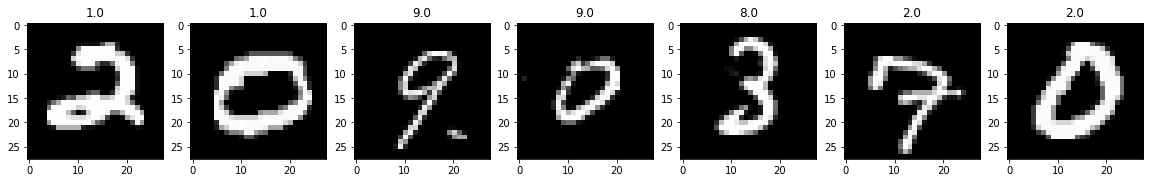

In [83]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:7], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_svm[i-1]);

In [29]:
predict_svm = svm_clf.predict(test_ln)

In [30]:
predict_svm

array([2., 0., 8., ..., 3., 9., 2.])

LogisticRegression

In [31]:
log_param = { 'C': np.array(range(1,27,3))*0.1,  
             'solver' : ['newton-cg', 'sag', 'lbfgs']    
}

In [32]:
grid = GridSearchCV(log_clf, log_param, scoring = 'accuracy', verbose = 5, n_jobs = -1)

In [33]:
grid.fit(x_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  2.4min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': array([0.1, 0.4, 0.7, 1. , 1.3, 1.6, 1.9, 2.2, 2.5]), 'solver': ['newton-cg', 'sag', 'lbfgs']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=5)

In [36]:
log_bp = grid.best_params_
log_bp

{'C': 2.5, 'solver': 'newton-cg'}

In [37]:
grid.best_score_

0.7110714285714286

In [38]:
log_clf =  LogisticRegression(**log_bp)

In [39]:
log_clf.fit(x_train, y_train)

LogisticRegression(C=2.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)

In [40]:
pred_log = log_clf.predict(x_val)

In [41]:
from sklearn.metrics import *
print('Accuracy: %s' % accuracy_score(y_val, pred_log))

Accuracy: 0.7130952380952381


In [42]:
print(classification_report(y_val, pred_log))

             precision    recall  f1-score   support

        0.0       0.72      0.68      0.70       816
        1.0       0.81      0.96      0.88       909
        2.0       0.64      0.63      0.64       846
        3.0       0.58      0.59      0.58       937
        4.0       0.76      0.78      0.77       839
        5.0       0.57      0.28      0.38       702
        6.0       0.79      0.85      0.82       785
        7.0       0.80      0.82      0.81       893
        8.0       0.65      0.64      0.64       835
        9.0       0.71      0.81      0.76       838

avg / total       0.70      0.71      0.70      8400



In [43]:
print(confusion_matrix(y_val, pred_log))

[[552  65  15  12  18  21  52   6  74   1]
 [ 11 869   6   0   0   0   9   1   7   6]
 [ 38  35 536  78  43  25  71   5  14   1]
 [ 34  20  90 555   5  65  18  23  95  32]
 [  8  13  20   0 658   7   7   8  11 107]
 [ 39  14  70 199  35 198  19  55  59  14]
 [ 25   2  75   6   7   0 668   1   1   0]
 [  0   4  11   4  18  17   0 736  12  91]
 [ 48  41   7 105  32  10   4  25 537  26]
 [  8   6   3   6  50   4   0  59  21 681]]


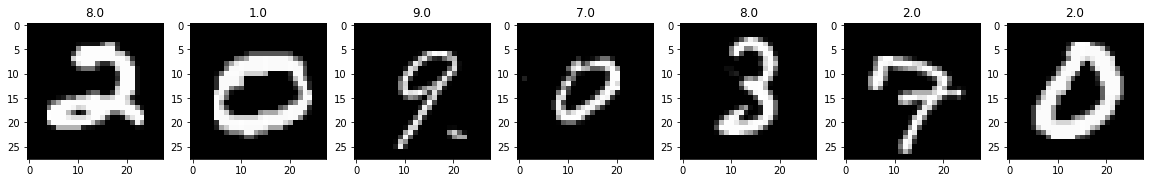

In [44]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:7], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_log[i - 1]);

In [45]:
predict_log = log_clf.predict(test_ln)

In [46]:
predict_log

array([2., 0., 9., ..., 3., 9., 2.])

## Готовим файл для отправки

In [47]:
with open('submit_log.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(predict_log, 1):
        dst.write('%d,%d\n' % (i, p))

In [48]:
# Your submission scored 0.71114

In [49]:
with open('submit_svm.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(predict_svm, 1):
        dst.write('%d,%d\n' % (i, p))

In [54]:
# Your submission scored 0.72642

Более точный результат дает классификация SVM. Результат accuracy 0.72642

# Используем данные полярных координат фильтра Собеля

Посмотрим каким будет результат, если использовать изображение после преобразований Собеля. Даст ли это лучший результат?

In [55]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [56]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

Используем только данные радиальной компоненты

In [57]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

In [60]:
train_theta[0].flatten().shape

(784,)

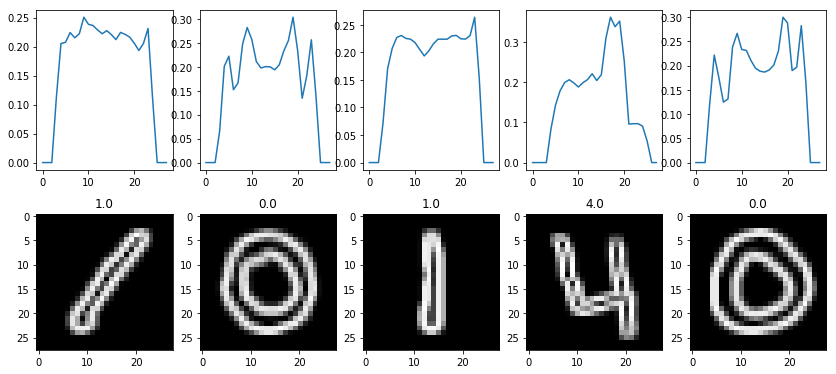

In [62]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.plot(range(0,28),img.sum(axis = 1)/np.linalg.norm(img.sum(axis = 1)))

In [63]:
train_sb = np.zeros((len(train_img), 28))
for i in range(len(train_img)):
    train_sb[i] = train_img[i].sum(axis = 1)/np.linalg.norm(train_img[i].sum(axis = 1))  

In [66]:
test_sb = np.zeros((len(test_img), 28))
for i in range(len(test_img)):
    test_sb[i] = test_img[i].sum(axis = 1)/np.linalg.norm(test_img[i].sum(axis = 1))  

In [68]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_sb, test_size=0.2,
    random_state=42)

Классификация SVM

In [70]:
svm_param  = { 'C' : np.array(range(1,27,3))*0.1,
              'decision_function_shape' : ['ovo', 'ovr']    
}
grid = GridSearchCV(svm_clf, svm_param, scoring = 'accuracy', verbose = 5, n_jobs = -1)

In [71]:
%%time
grid.fit(x_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed: 28.2min finished


Wall time: 29min 1s


GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=2.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': array([0.1, 0.4, 0.7, 1. , 1.3, 1.6, 1.9, 2.2, 2.5]), 'decision_function_shape': ['ovo', 'ovr']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=5)

In [72]:
svm_sb_bp = grid.best_params_
svm_sb_bp

{'C': 2.5, 'decision_function_shape': 'ovo'}

In [73]:
grid.best_score_

0.7411904761904762

In [75]:
svm_clf = svm.SVC(**svm_bp)
svm_clf.fit(x_train, y_train)

In [76]:
pred_svm = svm_clf.predict(x_val)

In [78]:
from sklearn.metrics import *
print('Accuracy: %s' % accuracy_score(y_val, pred_svm))

Accuracy: 0.7517857142857143


In [79]:
print(classification_report(y_val, pred_log))

             precision    recall  f1-score   support

        0.0       0.72      0.68      0.70       816
        1.0       0.81      0.96      0.88       909
        2.0       0.64      0.63      0.64       846
        3.0       0.58      0.59      0.58       937
        4.0       0.76      0.78      0.77       839
        5.0       0.57      0.28      0.38       702
        6.0       0.79      0.85      0.82       785
        7.0       0.80      0.82      0.81       893
        8.0       0.65      0.64      0.64       835
        9.0       0.71      0.81      0.76       838

avg / total       0.70      0.71      0.70      8400



In [80]:
print(confusion_matrix(y_val, pred_log))

[[552  65  15  12  18  21  52   6  74   1]
 [ 11 869   6   0   0   0   9   1   7   6]
 [ 38  35 536  78  43  25  71   5  14   1]
 [ 34  20  90 555   5  65  18  23  95  32]
 [  8  13  20   0 658   7   7   8  11 107]
 [ 39  14  70 199  35 198  19  55  59  14]
 [ 25   2  75   6   7   0 668   1   1   0]
 [  0   4  11   4  18  17   0 736  12  91]
 [ 48  41   7 105  32  10   4  25 537  26]
 [  8   6   3   6  50   4   0  59  21 681]]


In [ ]:
predict_svm_sb = svm_clf.predict(test_sb)

данные к отправке

In [85]:
with open('submit_svm_sb.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(predict_svm_sb, 1):
        dst.write('%d,%d\n' % (i, p))

In [ ]:
# Your submission scored 0.7&&&&

Классификация для изображений, обработанных фильтром Собеля дает более высокий результат, повышаясь до 0,75 (accuracy). Причина в том, что границы цифр после обработки этим фильтром однородее, пиксели границы близкой яркости, что также прослеживается от изображения к изображению. Достигается однородность данных.